In [115]:
#from IPython.external import mathjax; mathjax.install_mathjax()
import matplotlib
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import healpy as hp
import healpy.projector as pro
import astropy.units as u
import astropy.constants as c
import astropy.io.fits as fits
from   scipy.stats import gaussian_kde
from   scipy.stats import sigmaclip
import scipy
import pandas as pd
import pickle
from   pylab import arange, show, cm
import seaborn as sb
from scipy.stats import spearmanr
import seaborn as sb


%matplotlib inline


colors = ['tab:blue', 
          'tab:orange', 
          'tab:green', 
          'tab:red', 
          'tab:purple', 
          'tab:brown', 
          'tab:pink', 
          'tab:gray', 
          'tab:olive', 
          'tab:cyan']


fisColor  = colors[0]
irasColor = colors[1]
ircColor  = colors[2]
hfiColor  = colors[3]
WColor = colors[4]


fontsize=20




In [3]:
with open('../Data/maps_nest.pickle') as f:  # Python 3: open(..., 'rb')
    coords, planck_bb, planck_mw,  phot, phot_modesub, phot_mpsub = pickle.load(f)
planck_bb.columns



Index([u'$T$', u'$B$', u'$I_{dust}(545)$', u'$R_{PR1}$', u'$\tau_{353,PR1}$',
       u'$U$'],
      dtype='object')

%%latex
\section{Make band pass plot}

%%latex
\subsection{Load in the Filters}
Filters taken from \cite{doi15}

In [4]:
filters_dir = "/work1/users/aaronb/Databrary/Filters/"


iras12  = pd.read_csv(filters_dir+"filter_iras12", 
                      names= ['Wavelength','I12'],
                      header=0)
wise12  = pd.read_csv(filters_dir+"filter_W12", 
                      names= ['Wavelength','W12'],
                      header=0)
akari9  = pd.read_csv(filters_dir+"filter_akari9", 
                      names= ['Wavelength','AKARI9'],
                      header=0)
akari18 = pd.read_csv(filters_dir+"filter_akari18", 
                      names= ['Wavelength','AKARI18'],
                      header=0)
iras25  = pd.read_csv(filters_dir+"filter_iras25", 
                      names= ['Wavelength','I25'],
                      header=0)
iras60  = pd.read_csv(filters_dir+"filter_iras60", 
                      names= ['Wavelength','I60'],
                      header=0)

akari65  = pd.read_csv(filters_dir+"filter_akari65", 
                      names= ['Wavelength','AKARI65'],
                      header=0)

akari90  = pd.read_csv(filters_dir+"filter_akari90", 
                      names= ['Wavelength','AKARI90'],
                      header=0)

iras100  = pd.read_csv(filters_dir+"filter_iras100", 
                      names= ['Wavelength','I100'],
                      header=0)

akari140  = pd.read_csv(filters_dir+"filter_akari140", 
                      names= ['Wavelength','AKARI140'],
                      header=0)

akari160  = pd.read_csv(filters_dir+"filter_akari160", 
                      names= ['Wavelength','AKARI160'],
                      header=0)

planck857= pd.read_csv(filters_dir+"filter_planck857", 
                      names= ['Wavelength','PLANCK857'],
                      header=0)

planck545= pd.read_csv(filters_dir+"filter_planck545", 
                      names= ['Wavelength','PLANCK545'],
                      header=0)



%%latex
\subsection{MIR Data}

AttributeError: 'DataFrame' object has no attribute 'I12'

/work1/users/aaronb/Softbrary/Anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family [u'sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


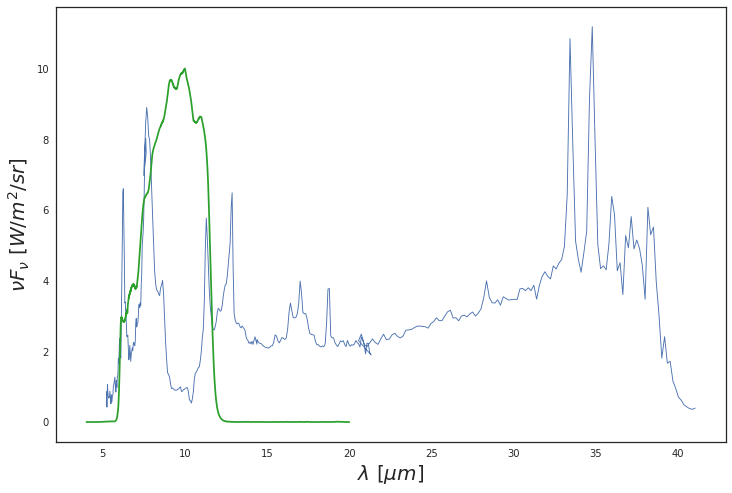

In [107]:
plt.figure(figsize = (12,8))
onakaMIR = pd.read_table('../Data/cirrus2 9_35_52  2005_02_26.txt', 
                      names= ['Wavelength','Spitzer/IRS'],
                      header=0)
onakaMIR['Spitzer/IRS']*u.Jy
onakaMIR['Spitzer/IRS'] *= c.c/onakaMIR['Wavelength']*u.um.to(u.m)
#print onakaMIR['MIR'][1]
#onakaMIR['Wavelength'] *= u.micron
#onakaMIR['MIR'].values.to(u.Joule)
with sb.axes_style("white"):
    plt.plot(onakaMIR['Wavelength'],
             onakaMIR['Spitzer/IRS'],
             label= 'Spitzer/IRS: Galactic plane', linewidth=0.9)
    plt.ylabel('$\\nu{}F_{\\nu}$ $[W/m^{2}/sr]$', fontsize=fontsize)
    plt.xlabel('$\lambda$ $[\mu{}m]$', fontsize=fontsize)
    plt.plot(akari9.Wavelength,akari9.AKARI9*10,label="A9", color=ircColor)
    plt.plot(iras12.Wavelength,iras12.I12*10,label="I12", color=irasColor)
    plt.plot(akari18.Wavelength,akari18.AKARI18*10,label="A18", color=ircColor)
    plt.plot(iras25.Wavelength,iras25.I25*10,label="I25", color=irasColor)
    plt.xlim(5,31)
    plt.ylim(0.8,15)
    plt.legend()
    #plt.vlines(6.2,7,10,linestyles = 'dashed')
    #plt.vlines(7.7,9,10,linestyles = 'dashed')
    #plt.vlines(11.2,6,10,linestyles = 'dashed')
    
    plt.savefig('../Plots/ch_datasources/Filter_coverage_example_MIR.pdf')
#scale_factor = 2.0 # Scales the obs data and models for visiblity

#onakaMIR.MIR*=scale_factor


/work1/users/aaronb/Softbrary/Anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:641: RuntimeWarning: overflow encountered in expm1
  *arrays, **kwargs)


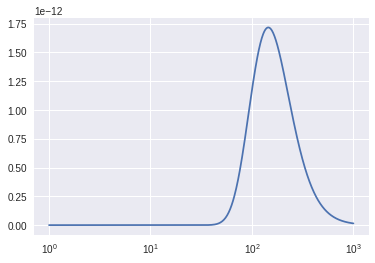

In [6]:
from astropy.modeling.blackbody import blackbody_lambda
bb_wave = np.linspace(1,1000,1000)*u.micron
bb = blackbody_lambda(bb_wave, 20*u.K)
plt.plot(bb_wave, bb.value*bb.value.max())
plt.xscale('log')

%%latex
\subsection{Modified black body: Emissivity 'correction'}

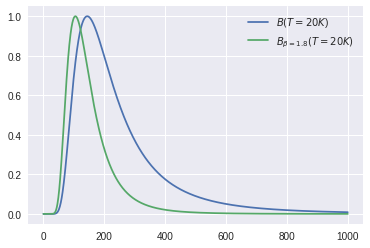

In [7]:
ref_wave = 550*u.micron # Arbitrary 'pivot' wavelength 
beta = 1.8 # Emissivity index
bb_corr = (ref_wave/bb_wave)**beta

mbb = bb *bb_corr


plt.plot(bb_wave, bb.value/bb.value.max(), label = '$B(T=20K$)')
plt.plot(bb_wave, mbb.value/mbb.value.max(), label = '$B_{\\beta{}=1.8}(T=20K)$')
#plt.xscale('log')
plt.legend()


mbb = pd.DataFrame(
    np.array([bb_wave,mbb]).T,
    columns=['Wavelength','MBB'])

#mbb.MBB/=mbb.MBB.max()

mbb.MBB /= mbb.Wavelength


#mbb.MBB*=scale_factor

### Import DustEM example SEDs

In [8]:
ex_SED_file = "../Data/SED_example_DustEM.txt"
#ex_SED = 
ex_SED = pd.DataFrame(
    np.genfromtxt(ex_SED_file),
    columns = ['Wavelength','PAH0','PAH1','acB0','acB1','aSil', 'Total'])
ex_SED.describe()


ex_SED_norm = ex_SED.copy()
ex_SED_norm[['PAH0','PAH1','acB0','acB1','aSil', 'Total']] /= ex_SED_norm['Total'].max()


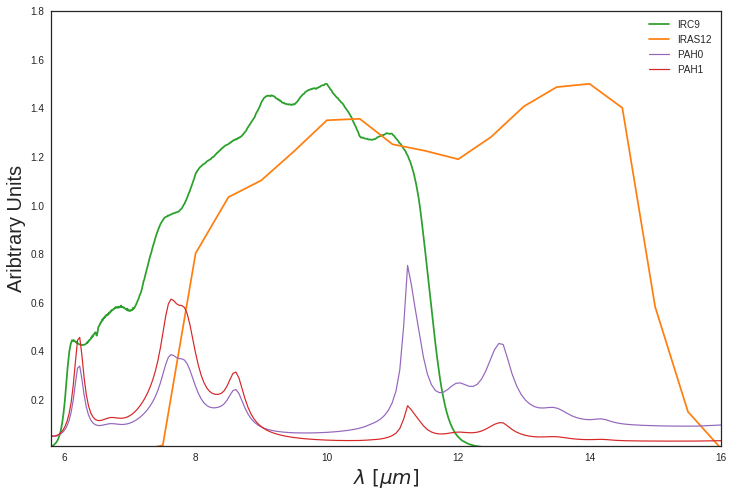

In [9]:
plt.figure(figsize = (12,8))

with sb.axes_style("white"):
    plt.ylabel('Aribtrary Units', fontsize=fontsize)
    plt.xlabel('$\lambda$ $[\mu{}m]$', fontsize=fontsize)
    plt.plot(akari9.Wavelength,akari9.AKARI9*1.5,label="A9", color=ircColor)
    plt.plot(iras12.Wavelength,iras12.I12*1.5,label="I12", color=irasColor)
    plt.plot(ex_SED_norm['Wavelength'],ex_SED_norm['PAH0'],linewidth=1.2, color =  colors[-6])
    plt.plot(ex_SED_norm['Wavelength'],ex_SED_norm['PAH1'],linewidth=1.2, color =  colors[-7])

    plt.legend()
    plt.ylim((0.01,1.8))
    plt.xlim((5.8,16))
    plt.savefig('../Plots/ch_datasources/Filter_coverage_example_PAH.pdf')
#scale_factor = 2.0 # Scales the obs data and models for visiblity

#onakaMIR.MIR*=scale_factor


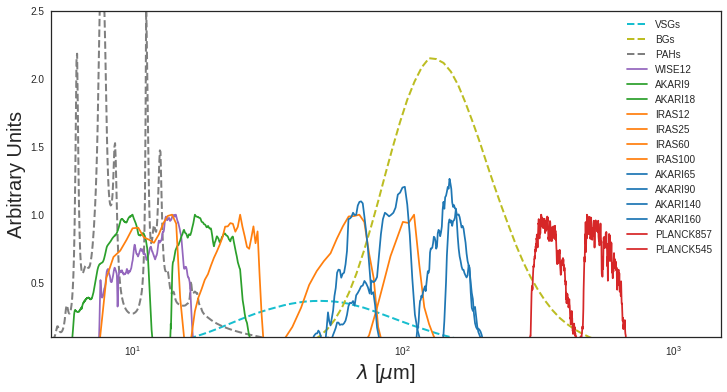

In [10]:
# Set ranges:
xmax = 1.5e3
xmin = 5
ymin = 0.1
ymax = 2.5
logx = True

#colors = sb.color_palette("tab")


with sb.axes_style("white"):

    fig = plt.figure(figsize = (12,6))
    #gs1 = gridspec.GridSpec(2, 1)
    #gs1.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 
    ax1 = fig.add_subplot(111)
    
#     ax1.plot(ex_SED_norm['Wavelength'],
#                      ex_SED_norm['Total']*2, 
#                      #linestyle = 'dashed',
#                      color = 'black',
#                      linewidth = 1,
#                      label = 'Dust SED')
    
    ax1.plot(ex_SED_norm['Wavelength'],
                     ex_SED_norm['acB0']*6, 
                     linestyle = 'dashed',
                     color = colors[-1],
                     linewidth = 2.0,
                     label = 'VSGs')
    
    ax1.plot(ex_SED_norm['Wavelength'],
                     (ex_SED_norm['acB1']+ex_SED_norm['aSil'])*2.75, 
                     linestyle = 'dashed',
                     color = colors[-2],
                     linewidth = 2.0,
                     label = 'BGs')
    
    ax1.plot(ex_SED_norm['Wavelength'],
                     (ex_SED_norm['PAH0']+ex_SED_norm['PAH1'])*2.75, 
                     linestyle = 'dashed',
                     color = colors[-3],
                     linewidth = 2.0,
                     label = 'PAHs')
    
    # Plot the filters
    #W12_norm['W12'] = (W12['W12'] - W12['W12'].mean()) / (W12['W12'].max() - W12['W12'].min())
    W12_norm = W12
    W12_norm['W12'] = (W12['W12']  / W12['W12'].max())

    W12_norm.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = WColor)
    
    akari9.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = ircColor)
    akari18.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = ircColor)
   
    iras12.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = irasColor)
    iras25.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = irasColor)
    iras60.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = irasColor)
    iras100.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = irasColor)
    
    akari65.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = fisColor)
    akari90.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = fisColor)
    akari140.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = fisColor)
    akari160.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color = fisColor)
    
    planck857.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax), ax=ax1, color=hfiColor)
    planck545.plot(x='Wavelength',logx=logx, xlim=(xmin,xmax),
                   ylim=(ymin,ymax),
                   ax=ax1, color = hfiColor)
    
    
    # Plot the MIR spectrum
    
    #onakaMIR.plot(x='Wavelength',y='MIR',xlim=(xmin,xmax),ylim = (ymin, ymax), ax = ax1)
    
    # Plot FIR modified blackbody
    
#     mbb.plot(x='Wavelength',
#              xlim=(xmin,xmax),
#              ylim = (ymin, ymax), 
#              ax = ax1)
    
    plt.xlabel('$\lambda$ [$\mu$m]', fontsize=fontsize)
    plt.ylabel("Arbitrary Units", fontsize=fontsize)
    plt.legend()
    plt.savefig('../Plots/ch_datasources/Filter_coverage_example_full.pdf')
    

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


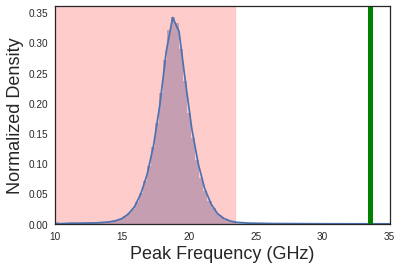

In [12]:
import matplotlib
with sb.axes_style("white"):
    fontsize = 18
    
    ame_freq_allsky = hp.read_map('../Data/raw/COM_CompMap_AME-commander_0256_R2.00_var_FREQ_MEAN.fits')
    plt.figure()
    nuhist = sb.distplot(ame_freq_allsky[ame_freq_allsky!=hp.UNSEEN],
                rug=False, bins = 200 )

    nuhist.set_xlim(10,35)
    nuhist.set_xlabel("Peak Frequency (GHz)", fontsize=fontsize)
    nuhist.set_ylabel("Normalized Density", fontsize=fontsize)
    #nuhist.set_title("Per-pixel AME $\\nu_{peak}$ not well constrained", fontsize=fontsize)
    nuhist.axvline(x=33.5, ymin=0, ymax = 1, linewidth=5, color='g')

    nuhist.axvspan(8, 23.5, alpha=0.2, color='red')
    plt.savefig("../Plots/ch_intro/AME_commander_freqdist.pdf")


In [13]:
cmap = cm.rainbow
cmap.set_under('w')

In [28]:
PCCS_crossmatrix = planck_mw.join(planck_bb[['$I_{dust}(545)$','$T$','$B$']]).corr(method='spearman')

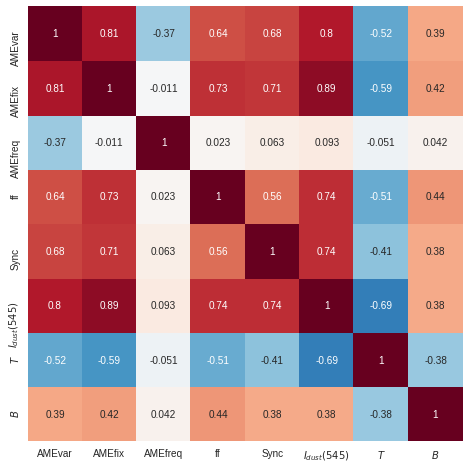

In [29]:
plt.figure(figsize=(8,8))
sb.heatmap(PCCS_crossmatrix,
          square=True,
          annot=True,
           cbar=False
          )
plt.savefig('../Plots/ch_datasources/PCCS_corrmatrix.pdf')

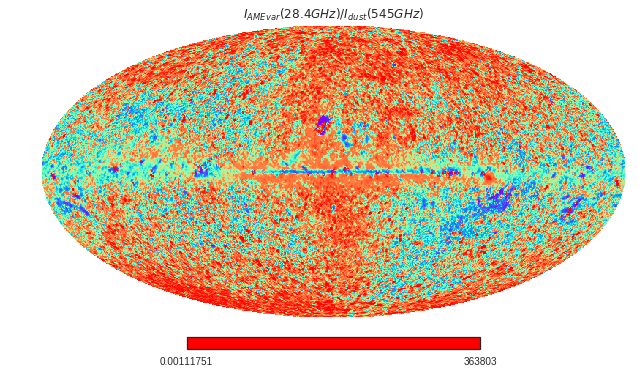

In [31]:
with sb.axes_style("white"):
    

    hp.mollview(planck_mw['AMEvar']/planck_bb['$I_{dust}(545)$'], 
                   norm='hist', 
                    nest=True, 
                    #min=1.5, max = 2.0, 
                    cmap=cmap,
                    title = '${I_{AME}}_{var}(28.4 GHz) / I_{dust}(545 GHz)$')
    plt.savefig('../Plots/ch_datasources/R_PCAMEtoPCRad.pdf')


    plt.savefig('../Plots/ch_datasources/PCAME_var_freq.pdf')

In [33]:
rand_seed = 42

sb.jointplot(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)[(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)<25) & (planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)>15)],
             np.log(planck_mw['AMEvar'].sample(random_state=rand_seed, frac=0.30)[(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)<25) & (planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)>15)]), 
             kind= 'hex',
            stat_func = spearmanr)
plt.savefig('../Plots/ch_allsky/AMEfreq_vs_var.pdf')

sb.jointplot(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)[(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)<25) & (planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)>15)],
             np.log(planck_mw['AMEfix'].sample(random_state=rand_seed, frac=0.30)[(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)<25) & (planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)>15)]), 
             kind= 'hex',
            stat_func = spearmanr)
plt.savefig('../Plots/ch_allsky/AMEfreq_vs_fix.pdf')


sb.jointplot(ancillframe['$H_{a}$'].divide(ancillframe['$N_{H}$']).sample(random_state=rand_seed, frac=0.30)[(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)<25) & (planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)>15)],
             np.log(planck_mw['AMEfix'].sample(random_state=rand_seed, frac=0.30)[(planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)<25) & (planck_mw['AMEfreq'].sample(random_state=rand_seed, frac=0.30)>15)]), 
             kind= 'hex',
            stat_func = spearmanr)

NameError: name 'spearmanr' is not defined

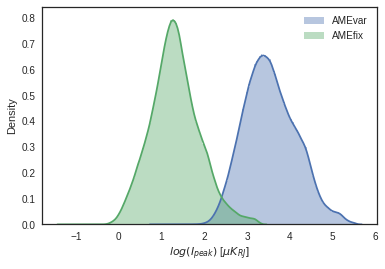

In [26]:
def plotClippedHist(data,sigma, log=False):
    c, upp, low = sigmaclip(data,sigma ,sigma)
    
    label = data.name
    
    with sb.axes_style("white"):
        if log == True:
            sb.distplot(np.log10(c), bins =300, label=label)
        else:
            sb.distplot(c, bins=300, label=label)
        
    plt.legend()
    
plotClippedHist(planck_mw['AMEvar'], 15, log=True)
plotClippedHist(planck_mw['AMEfix'], 15, log=True)
#plotClippedHist(planck_mw['AMErad'], 15, log=True)
plt.xlabel('$log(I_{peak})$ [$\mu{}K_{RJ}]$')
plt.ylabel('Density')
plt.savefig('../Plots/ch_datasources/AME_comps_distplot.pdf')

In [11]:
filters = pd.DataFrame.from_csv("/work1/users/aaronb/Codebrary/Python/filters_PAH.dat", header=0)

# Compare PAH Ionization fraction in different bands and stuff:

In [35]:
filters.columns

Index([u'IRAS12/PAH0', u'IRAS12/PAH1', u'IRAS12/SAmC', u'IRAS12/LAmC',
       u'IRAS12/ASIL', u'IRAS12/TOTAL', u'IRAS25/PAH0', u'IRAS25/PAH1',
       u'IRAS25/SAmC', u'IRAS25/LAmC', u'IRAS25/ASIL', u'IRAS25/TOTAL',
       u'WISE12/PAH0', u'WISE12/PAH1', u'WISE12/SAmC', u'WISE12/LAmC',
       u'WISE12/ASIL', u'WISE12/TOTAL', u'WISE22/PAH0', u'WISE22/PAH1',
       u'WISE22/SAmC', u'WISE22/LAmC', u'WISE22/ASIL', u'WISE22/TOTAL',
       u'IRC09/PAH0', u'IRC09/PAH1', u'IRC09/SAmC', u'IRC09/LAmC',
       u'IRC09/ASIL', u'IRC09/TOTAL', u'IRC18/PAH0', u'IRC18/PAH1',
       u'IRC18/SAmC', u'IRC18/LAmC', u'IRC18/ASIL', u'IRC18/TOTAL'],
      dtype='object')

In [90]:
filters.columns = [u'I12/PAH0', u'I12/PAH1', u'I12/SAmC', u'I12/LAmC',
       u'I12/ASIL', u'I12/TOTAL', u'I25/PAH0', u'I25/PAH1',
       u'I25/SAmC', u'I25/LAmC', u'I25/ASIL', u'I25/TOTAL',
       u'W12/PAH0', u'W12/PAH1', u'W12/SAmC', u'W12/LAmC',
       u'W12/ASIL', u'W12/TOTAL', u'W22/PAH0', u'W22/PAH1',
       u'W22/SAmC', u'W22/LAmC', u'W22/ASIL', u'W22/TOTAL',
       u'A9/PAH0', u'A9/PAH1', u'A9/SAmC', u'A9/LAmC',
       u'A9/ASIL', u'A9/TOTAL', u'A18/PAH0', u'A18/PAH1',
       u'A18/SAmC', u'A18/LAmC', u'A18/ASIL', u'A18/TOTAL']

%%latex
\section{PAH Ionization Fraction Example}

In [91]:
AmC = ['I12/SAmC', 'I12/LAmC',      
       'I25/SAmC', 'I25/LAmC', 
  'A09/SAmC','A18/SAmC']
ASIL = ['I12/ASIL',       'A9/ASIL']
PAH = ['A9/PAH0','A9/PAH1','I12/PAH0','I12/PAH1']


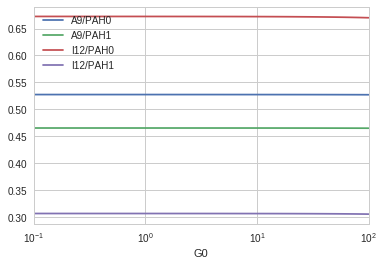

In [92]:
plt.figure(); filters[PAH].plot(logx=True)

Text(0,0.5,u'In-band Fractional Contribution')

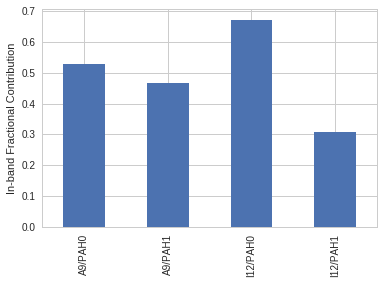

In [93]:
filters[PAH].ix[5].plot(kind='bar',
                        stacked=True); 
#plt.axhline(0, color='k')
plt.ylabel('In-band Fractional Contribution')

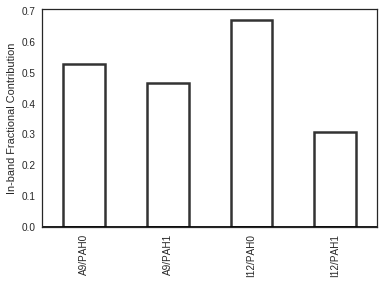

In [128]:
with sb.axes_style("white"):
    filters[PAH].ix[5].plot(kind='bar',
                            stacked=True,
                            sort_columns = ['A9/PAH1','I12/PAH1','I12/PAH0','A9/PAH0'],
                            **{'linewidth':2.5, 
                               'linewidth':2.5, 
                               'facecolor':(1, 1, 1, 0),
                               'edgecolor':(".2",".2",".2",".2")}); 
    plt.axhline(0, color='k')
    plt.ylabel('In-band Fractional Contribution')
    plt.savefig('../Plots/ch_datasources/InBandFracContribution_PAH.pdf')

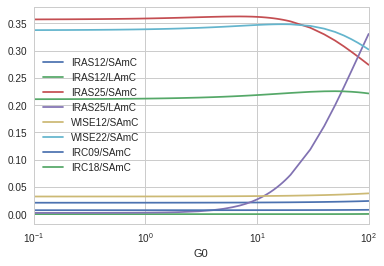

In [48]:
plt.figure(); 
filters[AmC].plot(logx=True)

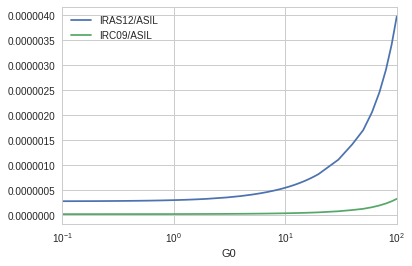

In [52]:
plt.figure(); 
filters[ASIL].plot(logx=True)

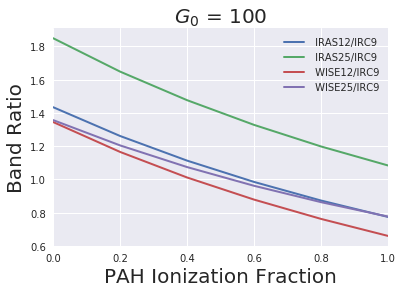

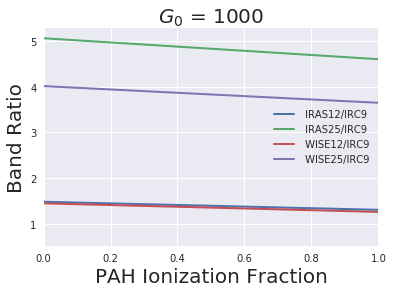

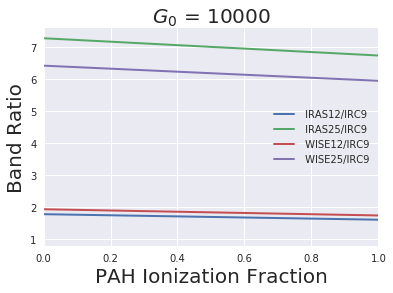

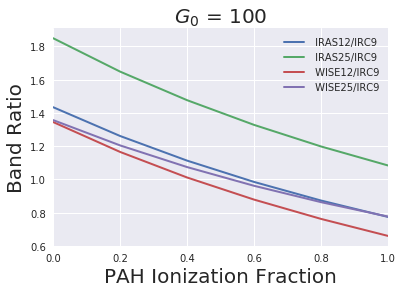

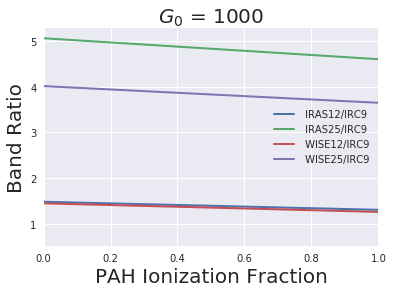

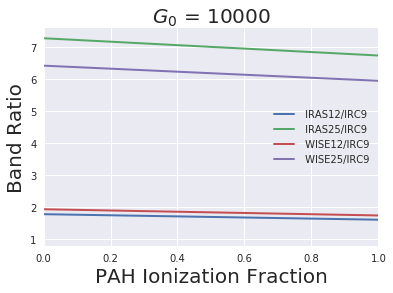

In [117]:
g100 = pd.DataFrame.from_csv("../Data/band-ratio-G100.dat",header=1)
#g100
g1000 = pd.DataFrame.from_csv("../Data/band-ratio-G1000.dat",header=1, index_col=None)
#g1000
g10000 = pd.DataFrame.from_csv("../Data/band-ratio-G10000.dat",header=1, index_col=None)
#g10000

def plot_ifrac(df,filename,g0):

    f = plt.figure()
    df[df.columns[-5:-1]].plot(ax=f.gca(),linewidth=2.0)
    plt.ylabel("Band Ratio",fontsize=20)
    plt.xlabel("PAH Ionization Fraction",fontsize=20)
    plt.xlim(0,1)
    plt.title("$G_{0}$ = "+str(g0),fontsize=20)
    f.show()
    f.savefig("../Plots/ch_datasources/"+filename)
    #plt.close()


plot_ifrac(g100, "band-ratio-G100.pdf", 100)
plot_ifrac(g1000, "band-ratio-G1000.pdf",1000)
plot_ifrac(g10000, "band-ratio-G10000.pdf",10000)

def plot_big_ifrac(df1,df2,df3,filename):

    fig = plt.figure()

    plt.ylabel("Band Ratio")

    ax1 = plt.subplot(311)
    
g100 = pd.DataFrame.from_csv("../Data/band-ratio-G100.dat",header=1)
#g100
g1000 = pd.DataFrame.from_csv("../Data/band-ratio-G1000.dat",header=1, index_col=None)
#g1000
g10000 = pd.DataFrame.from_csv("../Data/band-ratio-G10000.dat",header=1, index_col=None)
#g10000

def plot_ifrac(df,filename,g0):

    f = plt.figure()
    df[df.columns[-5:-1]].plot(ax=f.gca(),linewidth=2.0)
    plt.ylabel("Band Ratio",fontsize=20)
    plt.xlabel("PAH Ionization Fraction",fontsize=20)
    plt.xlim(0,1)
    plt.title("$G_{0}$ = "+str(g0),fontsize=20)
    f.show()
    f.savefig("../Plots/ch_datasources/"+filename)
    #plt.close()


plot_ifrac(g100, "band-ratio-G100.pdf", 100)
plot_ifrac(g1000, "band-ratio-G1000.pdf",1000)
plot_ifrac(g10000, "band-ratio-G10000.pdf",10000)


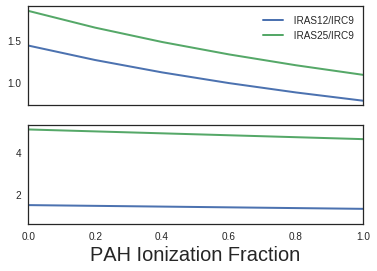

In [126]:

def plot_big_ifrac(df1,df2,filename):
    with sb.axes_style("white"):
        fig = plt.figure()

        plt.ylabel("Band Ratio")

        ax1 = plt.subplot(211)
        df1[df1.columns[-5:-3]].plot(ax=ax1,linewidth=2.0, )
        #plt.setp(ax1.get_xticklabels(), fontsize=6)

        ax2 = plt.subplot(212, sharex=ax1)
        plt.setp(ax2.get_xticklabels(), visible=True)
        df2[df2.columns[-5:-3]].plot(ax=ax2,legend=None, linewidth=2.0)
        plt.setp(ax1.get_xticklabels(), fontsize=6)

    
        plt.xlim(0,1)
        plt.xlabel("PAH Ionization Fraction",fontsize=20)
        #fig.ylabel("Band ratio")


        plt.show()
        plt.savefig("../Plots/ch_datasources/"+filename)

plot_big_ifrac(g100, g1000, "band-ratio-multiple.pdf")